# 基于MindSpore框架的GAN案例实现

在下面的教程中，我们将通过示例代码说明生成对抗网络GAN如何设置网络、优化器、如何计算损失函数以及如何初始化模型权重。本教程使用的是[MNIST手写数字数据集](http://yann.lecun.com/exdb/mnist/)，共有70000张手写数字图片，包含60000张训练样本和10000张测试样本，图片大小均为28\*28。

# 1 模型讲解

生成式对抗网络（Generative Adversarial Networks，GAN）是一种生成式机器学习模型，是近年来复杂分布上无监督学习最具前景的方法之一。

最初，GAN由Ian J. Goodfellow于2014年发明，并在论文[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中首次进行了描述，其主要由两个不同的模型共同组成——**生成器**(enerative Model)和**判别器**(Discriminative Model)：

- 生成器的任务是生成看起来像训练图像的“假”图像；
- 判别器需要判断从生成器输出的图像是真实的训练图像还是虚假的图像。

GAN通过设计生成模型和判别模型这两个模块，使其互相博弈学习产生了相当好的输出。



## 1.1 模型简介

GAN模型的核心在于提出了通过对抗过程来估计生成模型这一全新框架。在这个框架中，将会同时训练两个模型——捕捉数据分布的生成模型 $G$ 和估计样本是否来自训练数据的判别模型 $D$ 。

在训练过程中，生成器会不断尝试通过生成更好的假图像来骗过判别器，而判别器在这过程中也会逐步提升判别能力。这种博弈的平衡点是，当生成器生成的假图像和训练数据图像的分布完全一致时，判别器拥有50%的真假判断置信度。

我们首先定义会出现的标记符号：

**判别器的表示**

- $x$：代表图像数据；
- $D(x)$：判别器网络，给出图像判定为真实图像的概率；

在判别过程中，$D(x)$ 需要处理作为二进制文件的大小为 $1\times 28\times 28$ 的图像数据。当 $x$ 来自训练数据时，$D(x)$ 数值应该趋近于 $1$ ；而当 $x$ 来自生成器时，$D(x)$ 数值应该趋近于 $0$ 。因此 $D(x)$ 也可以被认为是传统的二分类器。

**生成器的表示**

- $z$：标准正态分布中采样出的隐码(隐向量)；
- $G(z)$：表示将隐码(隐向量) $z$ 映射到数据空间的生成器函数；

函数 $G(z)$ 的目标是**将服从高斯分布的随机噪声 $z$ 通过生成网络变换为近似于真实分布 $p_{data}(x)$ 的数据分布**，我们希望找到 $θ$ 使得 $p_{G}(x;\theta)$ 和 $p_{data}(x)$ 尽可能的接近，其中 $\theta$ 代表网络参数。

## 1.2 模型结构


$D(G(z))$ 表示生成器 $G$ 生成的假图像被判定为真实图像的概率，如[Generative Adversarial Nets论文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)中所述，生成器`G`和判别器`D`在进行一场博弈：

- `D` 想要最大程度的正确分类真图像与假图像，也就是最大化 $\log D(x)$；
- `G` 试图欺骗 `D` 来最小化假图像被识别到的概率，也就是最小化 $\log(1−D(G(z)))$。

因此GAN的损失函数为：

$$
\min\limits_{G}\max\limits_{D} V(D,G)=E_{x\sim p_{data}\;\,(x)}[\log D(x)]+E_{z\sim p_{z}\,(z)}[\log (1-D(G(z)))]
$$

从理论上讲，此博弈游戏的平衡点是$p_{G}(x;\theta) = p_{data}(x)$，此时判别器会随机猜测输入是真图像还是假图像。下面我们简要说明生成器和判别器的博弈过程：

![gan](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/gan_image.png)

在上图中，蓝色虚线表示判别器，黑色虚线表示真实数据分布，绿色实线表示生成器生成的虚假数据分布，$z$ 表示隐码，$x$ 表示生成的虚假图像 $G(z)$。

1. 在训练刚开始的时候，生成器和判别器的质量都比较差，生成器会随机生成一个数据分布。
2. 判别器通过求取梯度和损失函数对网络进行优化，将靠近真实数据分布的数据判定为1，将靠近生成器生成出来数据分布的数据判定为0。
3. 生成器通过优化，生成出更加贴近真实数据分布的数据。
4. 生成器所生成的数据和真实数据达到相同的分布，此时判别器的输出为1/2。

根据原论文中的训练方法，每轮训练都是在优化 `D` 的k步和优化 `G` 的1步之间交替进行，因此只要 `G` 变化得足够慢，便可保证 `D` 在其最优解附近。详细过程如下

![method](./step.png)



本案例将使用MNIST手写数字数据集来训练一个生成式对抗网络，接着使用该网络模拟生成手写数字图片。

此项目文件目录介绍如下：

```text
./mindspore_GAN
├─eval.py                     # 评估模型参数效果
├─data_loader.py              # 加载数据集
├─GAN.ipynb                   # 可独立运行总项目的notebook
├─structure.png               # GAN模型结构图
├─test.py                     # 测试模型参数
├─train.py                    # 训练
│      
├─data                        # 数据集
│
├─result
│  ├─gan_mnist.gif           # 保存训练中动图
│  ├─iter.png                # Loss迭代关系图
│  ├─src_data.png            # 抽取显示原始数据集图
│  │
│  ├─images\                 # 生成器生成结果图片
│  │
│  └─checkpoints\            # 模型参数
│
└─src
    ├─configs.py              # 超参数设置
    ├─GAN_model.py            # 模型网络结构
    ├─loss.py                 # 损失函数设置
    ├─TrainOneStep.py         # 训练一步代码
    └─utils.py                # 其他函数代码
```

# 2 案例演示——数据准备

本案例基于MindSpore 2.2.10 版本实现

## 2.1 数据下载

MindSpore提供基于Pipeline的数据引擎，通过数据集（Dataset）和数据变换（Transforms）实现高效的数据预处理。在本教程中，我们使用Mnist数据集，自动下载完成后，使用mindspore.dataset提供的数据变换进行预处理。

首先安装 `download` 包，然后执行命令下载并解压MNIST数据集（你也可以手动下载[MNIST](http://yann.lecun.com/exdb/mnist/)数据集并形成以下目录结构）：

```text
./MNIST_DATA
├── test
    ├── t10k-images-idx3-ubyte
    └── t10k-labels-idx1-ubyte
├── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

其中训练数据集包含60000张28\*28的手写数字图片的二进制编码文件，具体的编码格式可以在[原始数据集网站](http://yann.lecun.com/exdb/mnist/)获取到，在GAN模型中只需要用到训练数据集。

In [2]:
%pip install download
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 980.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 1.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 40.4MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


## 2.2 数据演示

 通过`mindspore.dataset.MnistDataset`直接读取MNIST数据集，mindspore会自动处理原始文件的编码格式，返回的数据集中包含图片和标签信息，图片数据的shape为`(28, 28, 1)`(HWC)，标签数据的形状为`()`(0-dim)。

In [2]:
from mindspore.dataset import MnistDataset

train_dataset = MnistDataset('MNIST_Data/train', shuffle=True)
print(train_dataset.get_dataset_size())
print(train_dataset.get_col_names())
for image, label in train_dataset.create_tuple_iterator():
    print(image.shape)
    print(image.dtype)
    print(label.shape)
    print(label.dtype)
    break

60000
['image', 'label']
(28, 28, 1)
UInt8
()
UInt32


 通过 `create_dict_iterator` 函数将数据转换成字典迭代器，然后使用 `matplotlib` 模块可视化部分训练数据。

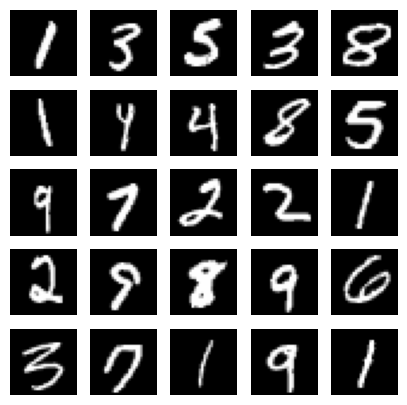

In [3]:
import matplotlib.pyplot as plt
src_data = './result/src_data.png'

# 可视化部分训练数据
def visualize(dataset):
    sample_iter = dataset.create_dict_iterator(output_numpy=True)
    sample = next(sample_iter)

    figure = plt.figure(figsize=(5, 5))
    cols, rows = 5, 5

    for idx in range(1, cols * rows + 1):
        image = sample['image']
        figure.add_subplot(rows, cols, idx)
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap="gray")
        sample = next(sample_iter)
    plt.savefig(src_data)
    plt.show()
    
visualize(train_dataset)

## 2.3 数据处理

首先为执行过程定义一些输入：

In [4]:
TRAIN_EPOCH = 200        # 训练周期数
LATENT_DIM = 100         # 隐向量的长度
BATCH_SIZE = 64          # 用于训练的训练集批量大小
lr = 0.0002               # 学习率
b1 = 0.5                  # Adam优化器的beta1超参数
b2 = 0.999                # Adam优化器的beta2超参数
channels = 1              # 图像通道数
img_size = 28             # 训练图像长宽大小
BATCH_SIZE_VALID = 1000   # 用于评估的验证集批量大小
BATCH_SIZE_TEST = 10      # 测试批量大小

定义 `create_dataset` 函数，用于创建数据集，该函数会利用mindspore的数据处理流水线（Data Processing Pipeline）对数据集进行预处理，利用`mindspore.dataset.transforms`中的`Compose`,接收一个数据处理操作序列，然后将其组合成单个数据处理，序列包括：

1. 将数据转换为float32类型
2. 将图像的像素值范围将从[0, 255]放缩为[0.0, 1.0]
3. 将数据集中的图片数据由HWC格式转换为CHW格式
3. 对数据集做Normalize

此后，再对数据集进行shuffle操作，打乱数据集中的元素顺序，使得每个元素被访问到的概率相同，然后再对数据集进行batch操作，将数据集中的元素组合成batch，此处batch_size为64

经过转换后，一个batch的数据shape为(128, 1, 28, 28)

In [5]:
from mindspore.dataset import transforms, vision
from mindspore.common import dtype as mstype

# 对数据集进行预处理，做好训练前的准备
def preprocess_dataset(dataset, batch_size=64):
    composed_operations = transforms.Compose(
        [
            vision.ToType(mstype.float32),
            vision.Rescale(1.0 / 255.0, 0),
            vision.HWC2CHW(),
            vision.Normalize(mean=(0.5,), std=(0.5,)),
        ]
    )
    dataset = dataset.map(composed_operations, "image")
    # 划分batch
    dataset = dataset.batch(batch_size, True)
    return dataset

# 获取处理后的数据集
train_dataset = preprocess_dataset(train_dataset, batch_size=BATCH_SIZE)
print(next(train_dataset.create_dict_iterator())["image"].shape)

(64, 1, 28, 28)


## 2.4 隐码(latent code)构造

为了跟踪生成器的学习进度，我们在训练的过程中的每轮epoch结束后，将一组固定的遵循高斯分布的隐码 `test_noise` 输入到生成器中，通过固定隐码所生成的图像来评估生成器的好坏。

 - 创建隐码代码如下

In [6]:
import numpy as np
from mindspore import Tensor
import random

# 利用随机种子创建一批隐码
np.random.seed(2323)
test_noise = Tensor(np.random.normal(size=(25, LATENT_DIM)), dtype=mstype.float32)
random.shuffle(test_noise)

# 3 案例演示——模型准备

当处理完数据后，就可以来进行网络的搭建了。

本案例实现中所搭建的GAN模型结构与2014年论文中提出的GAN结构大致相同，但由于所用数据集 MNIST 为单通道小尺寸图片，可识别参数少，便于训练，因此我们只需在判别器和生成器中采用全连接网络架构和Relu激活函数即可达到令人满意的效果。省略了原论文中用于减少参数的 `dropout` 和可学习激活函数 `maxout`。

本案例中采用模型图像如下所示：

![structure](./structure.png)

MindSpore框架构建网络的流程与PyTorch类似，在定义模型类时需要继承Cell类，并重写init和construct方法。

## 3.1 生成器

生成器 `Generator` 的功能是将隐码 `test_noise` 映射到数据空间。由于数据是图像，这一过程也会创建与真实图像大小相同的灰度图像(或RGB彩色图像)。在本案例演示中，该功能通过五层 `Dense` 全连接层来完成的，每层都与 `BatchNorm1d` 批归一化层和 `ReLu` 激活层配对，输出数据会经过 `Tanh` 函数，使其返回 `[-1,1]` 的数据范围内。

此外，我们通过输入部分中设置的 `latent_size`、`img_size` 和 `channels` 来影响代码中的生成器结构:

 - `latent_size` 是隐码 `latent_code` 的长度
 
 - `img_size` 与通过生成器传播的特征图的大小有关
 
 - `channels` 表示生成特征图的通道数


生成器的代码实现：

In [7]:
from mindspore import nn

class Generator(nn.Cell):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.SequentialCell(
            # [N, 100] -> [N, 128]
            nn.Dense(latent_dim, 128), #输入一个100维的0～1之间的高斯分布，然后通过第一层线性变换将其映射到256维
            nn.ReLU(),
            # [N, 128] -> [N, 256]
            nn.Dense(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # [N, 256] -> [N, 512]
            nn.Dense(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            # [N, 512] -> [N, 1024]
            nn.Dense(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            # [N, 1024] -> [N, 784]
            nn.Dense(1024, img_size * img_size),
            nn.Tanh(),  # 经过Tanh激活函数是希望生成的假的图片数据分布能够在[-1.0, 1.0]之间
        )

    def construct(self, x):
        x = self.model(x)
        return x.view(x.shape[0], channels, img_size, img_size)
    
# 实例化生成器
netGenerator = Generator(LATENT_DIM)

## 3.2 判别器

如前所述，判别器 `Discriminator` 是一个二分类网络模型，输出判定该图像为真实图的概率。主要通过一系列的 `Dense` 和 `LeakyReLU` 层对其进行处理，最后通过 `Sigmoid` 激活函数，使其返回 `[0, 1]` 的数据范围内，得到最终概率。


 判别器的代码实现如下：

In [8]:
class Discriminator(nn.Cell):
    def __init__(self, auto_prefix=True):
        super().__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell(
            # [N, 784] -> [N, 512]
            nn.Dense(img_size * img_size, 512),  #输入特征数为784，输出为512
            nn.LeakyReLU(),  #默认斜率为0.2的非线性映射激活函数
            # [N, 512] -> [N, 256]
            nn.Dense(512, 256),  #进行一个线性映射
            nn.LeakyReLU(),
            # [N, 256] -> [N, 1]
            nn.Dense(256, 1),
            nn.Sigmoid(),  #二分类激活函数，将实数映射到[0,1]
        )
    
    def construct(self, x):
        x_flat = x.view(x.shape[0], -1)
        return self.model(x_flat)
    
# 实例化判别器
netDiscriminator = Discriminator()

## 3.3 损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，因为GAN结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。所以我们需要自定义`WithLossCell`类，将网络和Loss连接起来。

当定义了 `Generator` 和 `Discriminator` 后，接下来将使用MindSpore中定义的二进制交叉熵损失[BCELoss](https://www.mindspore.cn/docs/zh-CN/r1.8/api_python/nn/mindspore.nn.BCELoss.html)作为基础损失metric，然后定义 `GeneratorLoss` 和 `DiscriminatorLoss` 两个损失函数，分别用于计算生成器和判别器的损失。

- 生成器损失函数的计算过程如下：

    1. 将从Gaussian分布中采样出的隐码 `latent` 通过生成器 `Generator` 生成假图像 `fake_img`；
    2. 将假图像 `fake_img` 通过判别器 `Discriminator` 得到假图像的判别结果 `fake_out`；
    3. 利用假图像和全1的Tensor计算二进制交叉熵损失，得到生成器的损失 `g_loss`，衡量 `Generator` 能够骗过 `Discriminator` 的能力；
    4. 后续要根据 `g_loss` 来反向传播更新 `Generator` 的参数
    

- 判别器损失函数的计算过程如下：
    
    1. 将真实图像 `real_img` 通过判别器 `Discriminator` 得到真实图像的判别结果 `real_out`；
    2. 将从Gaussian分布中采样出的隐码 `latent` 通过生成器 `Generator` 生成假图像 `fake_img`；
    3. 将假图像 `fake_img` 通过判别器 `Discriminator` 得到假图像的判别结果 `fake_out`；
    4. 利用真图像和全1的Tensor计算二进制交叉熵损失，得到真实图像的损失 `d_real_loss`；
    5. 利用假图像和全0的Tensor计算二进制交叉熵损失，得到假图像的损失 `d_fake_loss`；
    6. 令 `d_loss = d_real_loss + d_fake_loss`，衡量 `Discriminator` 能够区分真假图像的能力；
    7. 后续要根据 `d_loss` 来反向传播更新 `Discriminator` 的参数

In [9]:
from mindspore import nn
import mindspore.ops.functional as F

# 定义损失函数
adversarial_loss = nn.BCELoss(reduction='mean')

class GenWithLossCell(nn.Cell):
    def __init__(self, netG, netD, loss_fn):
        super(GenWithLossCell, self).__init__()
        self.netG = netG
        self.netD = netD
        self.loss_fn = loss_fn
    '''构建生成器损失计算结构'''
    def construct(self, latent):
        fake_img = self.netG(latent)
        fake_out = self.netD(fake_img)
        loss_G = self.loss_fn(fake_out, F.ones_like(fake_out))
        return loss_G

class DisWithLossCell(nn.Cell):
    def __init__(self, netG, netD, loss_fn):
        super(DisWithLossCell, self).__init__()
        self.netG = netG
        self.netD = netD
        self.loss_fn = loss_fn
    '''构建判别器损失计算结构'''
    def construct(self, real_data, latent):
        fake_img = self.netG(latent)
        fake_out = self.netD(fake_img)
        real_out = self.netD(real_data)

        d_fake_loss = self.loss_fn(fake_out, F.zeros_like(fake_out))
        d_real_loss = self.loss_fn(real_out, F.ones_like(real_out))

        loss_D = d_real_loss + d_fake_loss
        return loss_D

# 实例化
g_loss_fn = GenWithLossCell(netGenerator, netDiscriminator, adversarial_loss)
d_loss_fn = DisWithLossCell(netGenerator, netDiscriminator, adversarial_loss)

## 3.4 优化器

这里设置了两个单独的优化器，`optimizerD` 用于判别器，另一个 `optimizerG` 用于生成器。这两个都是 `lr = 0.0002` 和 `beta1 = 0.5，beta2 = 0.999` 的 `Adam` 优化器。

 - 以下是优化器的代码实现

In [10]:
# 为生成器和判别器设置优化器
optimizerG = nn.Adam(netGenerator.trainable_params(), learning_rate=lr, beta1=b1, beta2=b2)
optimizerD = nn.Adam(netDiscriminator.trainable_params(), learning_rate=lr, beta1=b1, beta2=b2)

# 4 案例演示——训练模型

## 4.1 训练准备

训练分为两个主要部分：训练判别器和训练生成器。

- 训练判别器:

   训练判别器的目的是最大程度地提高判别图像真伪的概率。
   
   按照[GAN原论文](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)的方法，希望通过提高其随机梯度来更新判别器，所以我们要最大化 $log D(x) + log(1 - D(G(z))$ 的值。


- 训练生成器:

   如论文所述，我们希望通过最小化 $log(1 - D(G(z)))$ 来训练生成器，以产生更好的虚假图像。

MindSpore2.0使用函数式自动微分机制，因此针对上述步骤需要实现：

1. 正向计算函数(forward_fn)定义。

2. 通过函数变换获得梯度计算函数。

3. 训练函数定义，执行正向计算、反向传播和参数优化。



定义单次训练过程的所需要的函数以及单次训练更新参数的流程：

In [11]:
import mindspore
def generator_forward_fn(noise):
    out = netGenerator(noise)
    loss = g_loss_fn(noise)
    return loss, out

def discriminator_forward_fn(real_img, noise):
    out = netDiscriminator(netGenerator(noise))
    loss = d_loss_fn(real_img, noise)
    return loss, out

generator_grad_fn = mindspore.value_and_grad(generator_forward_fn, None, optimizerG.parameters, has_aux=True)
discriminator_grad_fn = mindspore.value_and_grad(discriminator_forward_fn, None, optimizerD.parameters, has_aux=True)

def train_step(real_img, noise):
    (g_loss, _), g_grads = generator_grad_fn(noise)
    optimizerG(g_grads)
    (d_loss, _), d_grads = discriminator_grad_fn(real_img, noise)
    optimizerD(d_grads)
    return g_loss, d_loss

## 4.2 正式训练

在正式进行网络模型训练时，我们设置模型训练的 `epoch` 次数为200轮，并定义训练集 `batch_size` 大小为64。图像尺寸为28\*28，按照高斯分布初始化的25个隐码 `test_noise` 隐码向量长度为100。损失函数使用 `nn.BCELoss`。优化器使用 `nn.Adam`，并设置学习率为0.0002，beta两个超参数分别为0.5和0.999。

一般情况下，由于判别器效果提高较块，为保持两者平衡制约，会使判别器等待生成器，但在本案例中，为了简单起见，我们不设置等待机制。

在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计，将 `test_noise` 批量推送到生成器中，以直观地跟踪生成器 `Generator` 的训练进度。

每次迭代，均收集当时生成器和判别器的损失，以便于后面绘制训练过程中损失函数的图像(保存至./result/iter.png)。

每经过5次迭代，即保存生成器和判别器的网络模型参数(保存至./result/ipynb_checkpoints/)，以便于后面利用参数还原隐码生成的图片以及评估训练效果。

 - 模型训练部分的代码如下：

In [ ]:
import os
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import mindspore
from tqdm import tqdm
from mindspore import nn
from mindspore import ops
from mindspore import Tensor, context, save_checkpoint
from mindspore.common import dtype as mstype
from mindspore.common import set_seed
from mindspore.communication import init

# 设置参数保存路径
checkpoints_path = "./result/checkpoints"
os.makedirs(checkpoints_path, exist_ok=True)

# 设置中间过程生成图片保存路径
image_path = "./result/images"
os.makedirs(image_path, exist_ok=True)
def save_imgs(gen_imgs1, idx): # 保存生成的test图像
    for i3 in range(gen_imgs1.shape[0]):
        plt.subplot(5, 5, i3 + 1)
        plt.imshow(gen_imgs1[i3, 0, :, :]/2+0.5, cmap="gray")
        plt.axis("off")
    plt.savefig(image_path+"/{}.png".format(idx))

# Mindspore2.0默认执行模式为动态图模式(PYNATIVE_MODE)，指定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"
mindspore.set_context(device_target="GPU")

# set train
netGenerator.set_train(True)
netDiscriminator.set_train(True)
# 储存生成器和判别器loss
G_losses, D_losses = [], []

for epoch in range(TRAIN_EPOCH):
    start = time.time()
    iter_size = train_dataset.get_dataset_size()
    train_bar = tqdm(train_dataset, ncols=100, total=iter_size)
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    for (i, batch) in enumerate(train_bar):
        batch_imgs, _ = batch
        batch_size = batch_imgs.shape[0]
        batch_noise = Tensor(np.random.normal(size=(batch_size, LATENT_DIM)), dtype=mstype.float32)
        random.shuffle(batch_noise)
        g_loss, d_loss = train_step(batch_imgs, batch_noise)
        # if iter % 100 == 0:
        #     print('[%3d/%d][%3d/%d]  Loss_D:%6.4f  Loss_G:%6.4f' % (epoch+1, TRAIN_EPOCH, i+1, iter_size, d_loss.asnumpy(), g_loss.asnumpy()))
        g_loss_epoch += g_loss.asnumpy()
        d_loss_epoch += d_loss.asnumpy()
    D_losses.append(d_loss.asnumpy()/iter_size)
    G_losses.append(g_loss.asnumpy()/iter_size)
    end = time.time()
    print("time of epoch {} is {:.2f}s".format(epoch+1, end - start))

    # 每个epoch结束后，使用生成器生成一组图片
    netGenerator.set_train(False)
    gen_imgs = netGenerator(test_noise)
    netGenerator.set_train(True)
    save_imgs(gen_imgs.asnumpy(), epoch)

    # 保存网络模型参数为ckpt文件
    if(epoch % 5 == 0):
        save_checkpoint(netGenerator, checkpoints_path+"/Generator%d.ckpt" % (epoch))
        save_checkpoint(netDiscriminator, checkpoints_path+"/Discriminator%d.ckpt" % (epoch))

```text
100%|█████████████████████████████████████████████████████████████| 937/937 [00:36<00:00, 25.99it/s]
time of epoch 1 is 36.06s
100%|█████████████████████████████████████████████████████████████| 937/937 [00:36<00:00, 25.88it/s]
time of epoch 2 is 36.20s
100%|█████████████████████████████████████████████████████████████| 937/937 [00:36<00:00, 25.34it/s]
...
100%|█████████████████████████████████████████████████████████████| 937/937 [00:36<00:00, 25.53it/s]
time of epoch 198 is 36.70s
100%|█████████████████████████████████████████████████████████████| 937/937 [00:36<00:00, 25.58it/s]
time of epoch 199 is 36.63s
100%|█████████████████████████████████████████████████████████████| 937/937 [00:37<00:00, 25.22it/s]
time of epoch 200 is 37.15s
```

![last_img](./result/images/199.png)

# 5 案例演示——结果分析

## 5.1 迭代关系图

运行下面代码，描绘 `D_losses` 和 `G_losses` 损失与训练迭代的关系图：

In [ ]:
# 设置迭代关系图
iter_path = './result/iter.png'
def paintIters(D_losses, G_losses):
    plt.figure(figsize=(10, 10))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G", color='blue')
    plt.plot(D_losses, label="D", color='orange')
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(iter_path)
    plt.show()
    
paintIters(D_losses, G_losses)

![iter.png](./result/iter.png)


## 5.2 训练过程动图

为了更加直观的观察多轮训练后生成图像结果的变化，我们通过动图可视化，展现了训练过程中随着训练轮数的增加，通过隐码 `test_noise` 生成的图像不断完善。

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
image_list = []
for i in range(TRAIN_EPOCH):
    image_list.append(cv2.imread("./result/images/{}.png".format(i), cv2.IMREAD_GRAYSCALE))

gif_path = './result/gan_mnist.gif'
def showGif(image_list):
    show_list = []
    fig = plt.figure(dpi=120)
    for epoch in range(0, len(image_list), 5):
        plt.axis("off")
        show_list.append([plt.imshow(image_list[epoch], cmap='gray')])

    ani = animation.ArtistAnimation(fig, show_list, interval=10, repeat_delay=1000, blit=True)
    ani.save(gif_path, writer='pillow', fps=1)

showGif(image_list)

![gan_mnist](./result/gan_mnist.gif)

## 5.3 模型生成查看

从上面的图像可以看出，随着训练次数的增多，图像质量也越来越好。如果增大训练周期数，当 `num_epochs` 达到100以上时，生成的手写数字图片与数据集中的较为相似，下面我们通过加载训练周期为70的生成器网络模型参数文件[Generator170.ckpt](./result/checkpoints/Generator170.ckpt)来生成图像，代码如下：

In [ ]:
import mindspore
model = Generator(latent_dim=100)
param_dict = mindspore.load_checkpoint("./result/checkpoints/Generator170.ckpt")
mindspore.load_param_into_net(model, param_dict)

model.set_train(True)

# 生成图片
test_noise = Tensor(np.random.normal(0, 1, (25, 100)).astype(np.float32))
imgs = model(test_noise).transpose(0, 2, 3, 1).asnumpy()

fig = plt.figure(figsize=(5, 5))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.axis("off")
    plt.imshow(imgs[i].squeeze(), cmap="gray")
plt.savefig('./result/ckpt170_gen.png')
plt.show()

![ckpt170_gen](./result/ckpt170_gen.png)


## 5.4 模型检验

在GAN原文中，使用了Parzen Window方法。

Parzen Window是一种应用广泛的非参数估计方法，从采样的样本中估计概率密度函数。这种方法最基本的思想是给定一个特定的区域（Window）对落入其中的样本进行计数，可以得到样本落入该区域的概率。这里Window由核函数确定，根据原文，这里基于高斯分布设计核函数，其中的参数 $\sigma$ 确定核宽度，采用交叉验证获得。

对于我们的项目，实现思路大致是：产生的样本通过高斯核Parzen窗口法计算出一个概率模型 $P_g$（784维的高斯分布），然后估计测试样本的概率，从而计算出在该分布下的对数似然性，方差参数采用在验证集上交叉验证来获得。

具体流程如下：

 1. 利用函数 `mind_parzen` 定义Gauss Parzen Window

 2. 通过 `get_nll` 函数获得似然值

 3. 利用函数 `cross_validate_sigma` 在验证集上进行交叉检验

 4. 计算对数最大似然估计结果

 - 代码实现情况如下：


In [ ]:
import gc
import numpy as np
import matplotlib.pyplot as plt

import mindspore.numpy
from mindspore.common import dtype as mstype
from mindspore.common import set_seed
from mindspore import Tensor

set_seed(1)
reshape = mindspore.ops.Reshape()
log = mindspore.ops.Log()
exp = mindspore.ops.Exp()
cat = mindspore.ops.Concat()
cat2 = mindspore.ops.Concat(1)
squeeze1 = mindspore.ops.Squeeze(1)
sigma = None

# log_mean_exp函数计算平均值
def log_mean_exp(a):
    max_ = a.max(axis=1)
    max2 = reshape(max_, (max_.shape[0], 1))
    return max_ + log(exp(a - max2).mean(1))

# 使用parzen进行模型评估，设计窗口函数
def mind_parzen(x, mu, sigma):
    a = (reshape(x, (x.shape[0], 1, x.shape[-1])) - reshape(mu, (1, mu.shape[0], mu.shape[-1]))) / sigma
    a5 = -0.5 * (a ** 2).sum(2)
    E = log_mean_exp(a5)
    t4 = sigma * np.sqrt(np.pi * 2)
    t5 = np.log(t4)
    Z = mu.shape[1] * t5
    return E - Z

# 通过get_nll函数获得似然值，其中的操作是每次输入一个batch_size,最后对各个batch_size求取平均值
def get_nll(x, samples, sigma, batch_size=10):
    inds = list(range(x.shape[0]))
    n_batches = int(np.ceil(float(len(inds)) / batch_size))

    nlls = Tensor(np.array([]).astype(np.float32))
    for i in range(n_batches):
        nll = mind_parzen(x[inds[i::n_batches]], samples, sigma)
        nlls = cat((nlls, nll))
    return nlls

# 在验证集上进行交叉检验
def cross_validate_sigma(samples, data, sigmas, batch_size):
    lls = Tensor(np.array([]).astype(np.float32))
    for sigma in sigmas:
        print("sigma=", sigma)
        tmp = get_nll(data, samples, sigma, batch_size=batch_size)
        tmp = reshape(tmp.mean(), (1, 1))
        tmp = squeeze1(tmp)
        lls = cat((lls, tmp))
        gc.collect()

    ind = lls.argmax()
    return sigmas[ind]

# 获取有效的验证图像
def get_valid(batch_size_valid=1000):
    dataset = MnistDataset("MNIST_Data/train", "train")
    dataset = dataset.map(
        operations=lambda x: (
            x[-10000:].astype("float32")
        ),
        output_columns=["image"]
    )
    dataset = dataset.batch(batch_size_valid)
    for data in dataset.create_dict_iterator():
        image = data["image"]
        break
    print(type(image))
    image = reshape(image, (image.shape[0], 784))
    return image

# 获取测试图像
def get_test(limit_size):
    dataset_ = MnistDataset("MNIST_Data/test", "test").batch(limit_size)
    for batch_imgs, _ in dataset_.create_tuple_iterator():
        batch_imgs = batch_imgs.astype(mindspore.float32)
        test_data = reshape(batch_imgs, (batch_imgs.shape[0], -1))
        break
    return test_data
    

# 使用对数最大似然进行评估
def parzen(samples):
    ll, se = [1], 1
    shape = samples.shape
    samples = reshape(samples, (shape[0], -1))
    
    valid = get_valid(batch_size_valid=BATCH_SIZE_VALID).asnumpy()
    valid = Tensor(valid / 255)

    sigma_range = np.logspace(-1, 0, num=5)  # 等比数列
    sigma = cross_validate_sigma(samples, valid, sigma_range, batch_size=BATCH_SIZE_TEST)

    # print("Using Sigma: {}".format(sigma))
    gc.collect()

    test_data = get_test(limit_size=1000) / 255
    ll = get_nll(test_data, samples, sigma, batch_size=BATCH_SIZE_TEST)
    se = ll.std() / np.sqrt(test_data.shape[0])

    return ll.mean(), se

test_noise = Tensor(np.random.normal(size=(1000, LATENT_DIM)), dtype=mstype.float32)
llh, epochs = [], []
def eval(n):
    # 导入生成器参数
    model = Generator(latent_dim=LATENT_DIM)
    param_dict = mindspore.load_checkpoint("./result/checkpoints/Generator"+str(n)+".ckpt")
    mindspore.load_param_into_net(model, param_dict)
    # 生成噪音数据
    samples1 = model(test_noise)
    fake_img = Tensor((samples1.asnumpy() * 127.5 + 127.5) / 255)
    fake_img = reshape(fake_img, (fake_img.shape[0], 784))
    # 计算对数最大似然估计
    mean_ll, se_ll = parzen(fake_img)
    epochs.append(n)
    llh.append(mean_ll)
    print("epoch = {}, Log-Likelihood of test set = {}, se: {}".format(n, mean_ll, se_ll))
    
for epoch in range(0, TRAIN_EPOCH, 5):
    eval(epoch)
llh = [i.asnumpy() for i in llh]
plt.plot(epochs, llh)
eval_path = "./result/eval.png"
plt.savefig(eval_path)
plt.show()

```text
epoch = 0, Log-Likelihood of test set = -96.4416, se: 2.6014142
epoch = 5, Log-Likelihood of test set = -35.589073, se: 2.5585263
epoch = 10, Log-Likelihood of test set = 4.5607214, se: 8.061318
epoch = 15, Log-Likelihood of test set = 19.86148, se: 8.14705
...
epoch = 20, Log-Likelihood of test set = 30.325407, se: 7.6496964
epoch = 180, Log-Likelihood of test set = 68.78946, se: 8.006664
epoch = 185, Log-Likelihood of test set = 84.178215, se: 7.6321263
epoch = 190, Log-Likelihood of test set = 73.52148, se: 7.8675313
epoch = 195, Log-Likelihood of test set = 72.86262, se: 7.974557
```

![eval](./result/eval.png)

# 6 总结

本案例基于MindSpore框架针对MNIST数据集，完成了数据读取、数据集构建、GAN模型构建，并根据特定需求自定义了训练轮数和模型框架，进行了模型训练和可视化检验，顺利完成了生成结果的输出。通过此案例进一步加深了对GAN模型结构和特性的理解，并结合MindSpore框架提供的文档和教程，掌握了利用Mindspore框架实现特定案例的流程，以及多种API的使用方法，重点围绕利用Mindspore2.0的面向对象和函数式编程的新特性实现，为以后在实际场景中应用MindSpore框架提供支持。